In [1]:
# menghubungkan colab dengan google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
)


In [3]:
df = pd.read_csv("/content/gdrive/MyDrive/Semester 3/Matkul Machine Learning/Praktikum/4/Data/stunting_wasting_dataset.csv")
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


In [5]:
df.isnull().sum()

,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


In [9]:
df['Stunting'].unique()


array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

In [10]:
df['Jenis Kelamin'].unique()

array(['Laki-laki', 'Perempuan'], dtype=object)

In [11]:
map_stunt = {'Stunting': 1, 'Severely Stunted': 1, 'Normal': 0, 'Tall': 0}
df['Stunting_bin'] = df['Stunting'].map(map_stunt).astype('Int64')
df['JK_bin'] = (df['Jenis Kelamin'] == 'Laki-laki').astype('int')
print("Distribusi Stunting_bin: \n", df['Stunting_bin'].value_counts())
print("Distribusi JK_bin: \n", df['JK_bin'].value_counts())

Distribusi Stunting_bin: 
 Stunting_bin
0    78021
1     5819
Name: count, dtype: Int64
Distribusi JK_bin: 
 JK_bin
1    50179
0    49821
Name: count, dtype: int64


In [12]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.875869,0.665389,-0.026569,0.004046
Tinggi Badan (cm),0.875869,1.000000,0.626005,-0.242181,0.073505
Berat Badan (kg),0.665389,0.626005,1.000000,-0.021854,0.045797
Stunting_bin,-0.026569,-0.242181,-0.021854,1.000000,0.004442
JK_bin,0.004046,0.073505,0.045797,0.004442,1.000000


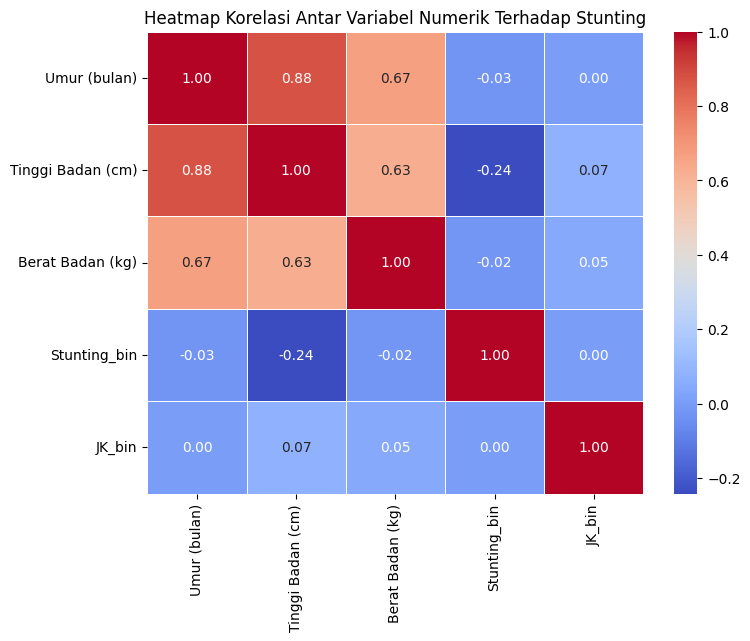

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Variabel Numerik Terhadap Stunting", fontsize=12)
plt.show()

In [15]:
feature_num = ['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

use_cols = feature_num + feature_bin + ['Stunting_bin']
df_use = df[use_cols].dropna().copy()

X = df_use[feature_num + feature_bin]
y = df_use['Stunting_bin']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (83840, 4)
y shape: (83840,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)

Data latih: (67072, 4)
Data uji: (16768, 4)


In [17]:
# Scale hanya fitur numerik, gender langsung passthrough
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin),
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('preprocess', preprocess),
    ('model', model)
])

# Latih model
clf.fit(X_train, y_train)
print("✅ Model Logistic Regression berhasil dilatih.")


✅ Model Logistic Regression berhasil dilatih.


In [18]:
# Prediksi & probabilitas
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Hitung metrik evaluasi
print(f"Akurasi   : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall    : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1 Score  : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC   : {roc_auc_score(y_test, y_prob):.4f}")


Akurasi   : 0.9427
Precision : 0.5481
Recall    : 0.9991
F1 Score  : 0.7079
ROC-AUC   : 0.9836


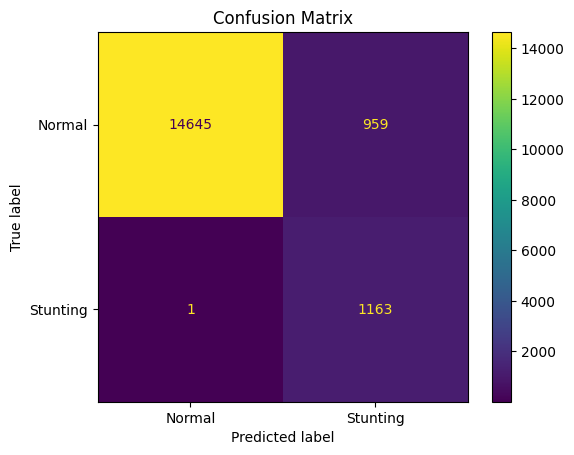

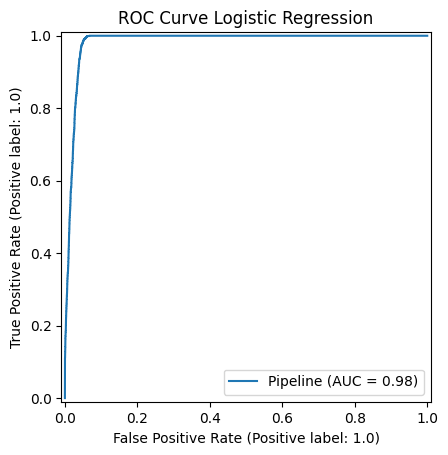

In [19]:
# Confusion Matrix
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=['Normal', 'Stunting']
).plot(values_format='d')

plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve Logistic Regression")
plt.show()


In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Tidak Stunting (0)', 'Stunting (1)']))

                    precision    recall  f1-score   support

Tidak Stunting (0)       1.00      0.94      0.97     15604
      Stunting (1)       0.55      1.00      0.71      1164

          accuracy                           0.94     16768
         macro avg       0.77      0.97      0.84     16768
      weighted avg       0.97      0.94      0.95     16768



In [23]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5)

print("Skor tiap fold:", scores)
print("Rata-rata akurasi:", np.mean(scores))
print("Standar deviasi:", np.std(scores))

Skor tiap fold: [0.94250954 0.93821565 0.94221135 0.93863311 0.93684399]
Rata-rata akurasi: 0.9396827290076336
Standar deviasi: 0.00226703731795664


In [24]:
feat_names = feature_num + feature_bin
coefs = clf.named_steps['model'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'Fitur': feat_names,
    'koefisien (log-odds)': coefs,
    'odds Ratio (e^coef)': odds
}).sort_values('odds Ratio (e^coef)', ascending=False)

display(coef_df)

,Fitur,koefisien (log-odds),odds Ratio (e^coef)
0,Umur (bulan),11.410722,9.028462e+04
3,JK_bin,2.462657,1.173596e+01
2,Berat Badan (kg),0.892433,2.441061e+00
1,Tinggi Badan (cm),-14.377466,5.700934e-07


In [26]:
data_baru = pd.DataFrame({
    'Umur (bulan)': [24, 10],
    'Tinggi Badan (cm)': [79.0, 72.5],
    'Berat Badan (kg)': [9.2, 7.8],
    'JK_bin': [1, 0]
})

pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:, 1]

hasil = data_baru.copy()
hasil['Prob_Stunting'] = prob
hasil['Pred (0=Tidak, 1=Ya)'] = pred

display(hasil)

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,Prob_Stunting,"Pred (0=Tidak, 1=Ya)"
0,24,79.0,9.2,1,0.999289,1.0
1,10,72.5,7.8,0,0.000057,0.0
